In [70]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_base = os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1")
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from data.small_context import get_bitcoin_datasets
from data.small_context import get_bitcoin_datasets_hourly

from models.validation_likelihood_tuning import get_autotuned_predictions_data

%load_ext autoreload
%autoreload 2

def plot_preds(train, test, pred_dict, model_name, show_samples=False, save_index = 0):
    save_folder = "./plot/" + str(save_index)
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.savefig(save_folder)
    plt.show()


def plot_preds_candles(df, train, test, pred_dict, model_name, show_samples=False, save_index = 0):

    save_folder = "./plot/" + str(save_index)
    pred = pred_dict['median']
    pred = pd.Series(pred)
    index = len(train)

    opens = pd.Series(df['open'].values, index=df['timestamp'])
    truth = pd.Series(df['close'].values, index=df['timestamp'])
    highs = pd.Series(df['high'].values, index=df['timestamp'])
    lows = pd.Series(df['low'].values, index=df['timestamp'])

    plt.figure(figsize=(8, 6), dpi=100)

    ## Draw candles
    height = truth - opens
    bottom = np.where(height > 0, opens, truth + abs(height))
    color = np.where(height > 0, 'g', 'r')

    plt.bar(range(len(truth)), height, bottom=bottom, color=color, align='center')
    plt.vlines(range(len(highs)), ymin=lows, ymax=highs, color=color, linewidth=1)            

    plt.plot(range(index, index + len(pred)), pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(range(index, index + len(pred)), lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(range(index, index + len(pred)), samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

    index_to_display = range(0, len(truth), len(truth) // 6)
    truth.index = truth.index.date
    display_date = truth.index[index_to_display]
    plt.xticks(index_to_display, display_date)

    # plt.xticks(range(len(truth)), truth.index)
    # plt.grid()

    plt.savefig(save_folder)
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define models ##

In [11]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    # 'LLMTime GPT-3': {'model': 'text-davinci-004', **gpt3_hypers},
    # 'PromptCast GPT-3': {'model': 'text-davinci-004', **promptcast_hypers},
    # 'ARIMA': arima_hypers,
    
}

model_predict_fns = {
    'LLMTime GPT-3.5': get_llmtime_predictions_data,
    # 'LLMTime GPT-3': get_llmtime_predictions_data,
    'LLMTime GPT-4': get_llmtime_predictions_data,
    # 'PromptCast GPT-3': get_promptcast_predictions_data,
    # 'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())

In [4]:
starting_date = '2023-11-01'
index = 0
for predict_step in [72,120,168] :

    with open(f"datasets/bitcoin/BTC_BitHourly.csv") as f:
        df = pd.read_csv(f, usecols=[0, 5], parse_dates=[0])
        mask = (df["timestamp"] > starting_date) 
        df = df.loc[mask]

        start_date = df["timestamp"].iloc[0]
        end_date = df["timestamp"].iloc[-1]

        print("Data set : BTC_Daily_ohlc")
        print(f"from {start_date} to {end_date}")
        print(f"{df.shape[0]} data points, training on {df.shape[0]- predict_step} and forecasting on {predict_step} points")
        print("Imput is scaled closing price")

    datasets = get_bitcoin_datasets_hourly(predict_steps=predict_step, timestamp="2023-11-01")
    ds_name = 'BTC_BitHourly'


    data = datasets[ds_name]
    train, test = data # or change to your own data
    print(train)

Data set : BTC_Daily_ohlc
from 2023-11-01 01:00:00 to 2023-11-29 10:00:00
682 data points, training on 610 and forecasting on 72 points
Imput is scaled closing price
timestamp
2023-11-01 01:00:00    34439.0
2023-11-01 02:00:00    34392.0
2023-11-01 03:00:00    34487.0
2023-11-01 04:00:00    34553.0
2023-11-01 05:00:00    34652.0
                        ...   
2023-11-26 06:00:00    37823.0
2023-11-26 07:00:00    37757.0
2023-11-26 08:00:00    37809.0
2023-11-26 09:00:00    37764.0
2023-11-26 10:00:00    37710.0
Length: 610, dtype: float64
Data set : BTC_Daily_ohlc
from 2023-11-01 01:00:00 to 2023-11-29 10:00:00
682 data points, training on 562 and forecasting on 120 points
Imput is scaled closing price
timestamp
2023-11-01 01:00:00    34439.0
2023-11-01 02:00:00    34392.0
2023-11-01 03:00:00    34487.0
2023-11-01 04:00:00    34553.0
2023-11-01 05:00:00    34652.0
                        ...   
2023-11-24 06:00:00    37257.0
2023-11-24 07:00:00    37309.0
2023-11-24 08:00:00    37301.0

Data set : BTC_Daily_ohlc
from 2023-11-01 01:00:00 to 2023-11-29 10:00:00
682 data points, training on 610 and forecasting on 72 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_BitHourly'}) 
 with NLL inf


100%|██████████| 1/1 [00:12<00:00, 12.31s/it]


targets [37767. 37762. 37788. 37801. 37804. 37814. 37784. 37788. 37728. 37706.
 37641. 37547. 37373. 37461. 37249. 37293. 37264. 37395. 37603. 37631.
 37672. 37460. 37506. 37509. 37322. 37322. 37383. 37307. 37284. 37299.
 37348. 37369. 37117. 37040. 36976. 36953. 36801. 36763. 37084. 36920.
 36976. 36880. 36807. 37036. 37086. 37240. 37267. 37202. 37183. 37132.
 37002. 36922. 37108. 37108. 36940. 37087. 37107. 37251. 37206. 37421.
 37375. 37527. 37885. 38273. 38023. 38151. 38274. 37972. 37885. 37839.
 37940. 38060.]
median timestamp
2023-11-26 11:00:00    37734.829400
2023-11-26 12:00:00    37720.563950
2023-11-26 13:00:00    37737.206975
2023-11-26 14:00:00    37741.962125
2023-11-26 15:00:00    37749.094850
                           ...     
2023-11-29 06:00:00    37718.186375
2023-11-29 07:00:00    37696.788200
2023-11-29 08:00:00    37718.186375
2023-11-29 09:00:00    37732.451825
2023-11-29 10:00:00    37725.319100
Length: 72, dtype: float64
Raw list completion :
[[' 9 8 7 , 9 7 5

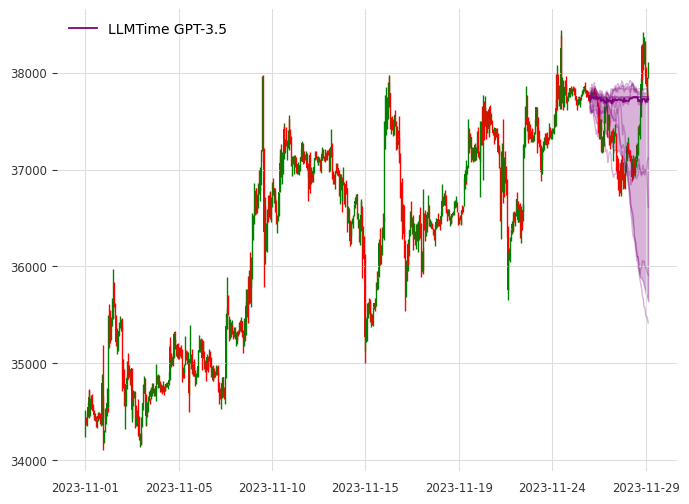

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_BitHourly'}) 
 with NLL inf


100%|██████████| 1/1 [00:14<00:00, 14.16s/it]


targets [37767. 37762. 37788. 37801. 37804. 37814. 37784. 37788. 37728. 37706.
 37641. 37547. 37373. 37461. 37249. 37293. 37264. 37395. 37603. 37631.
 37672. 37460. 37506. 37509. 37322. 37322. 37383. 37307. 37284. 37299.
 37348. 37369. 37117. 37040. 36976. 36953. 36801. 36763. 37084. 36920.
 36976. 36880. 36807. 37036. 37086. 37240. 37267. 37202. 37183. 37132.
 37002. 36922. 37108. 37108. 36940. 37087. 37107. 37251. 37206. 37421.
 37375. 37527. 37885. 38273. 38023. 38151. 38274. 37972. 37885. 37839.
 37940. 38060.]
median timestamp
2023-11-26 11:00:00    37720.51135
2023-11-26 12:00:00    37738.21220
2023-11-26 13:00:00    37755.91305
2023-11-26 14:00:00    37755.91305
2023-11-26 15:00:00    37755.91305
                          ...     
2023-11-29 06:00:00    37773.61390
2023-11-29 07:00:00    37755.91305
2023-11-29 08:00:00    37773.61390
2023-11-29 09:00:00    37755.91305
2023-11-29 10:00:00    37738.21220
Length: 72, dtype: float64
Raw list completion :
[['1065, 1066, 1067, 1066, 1

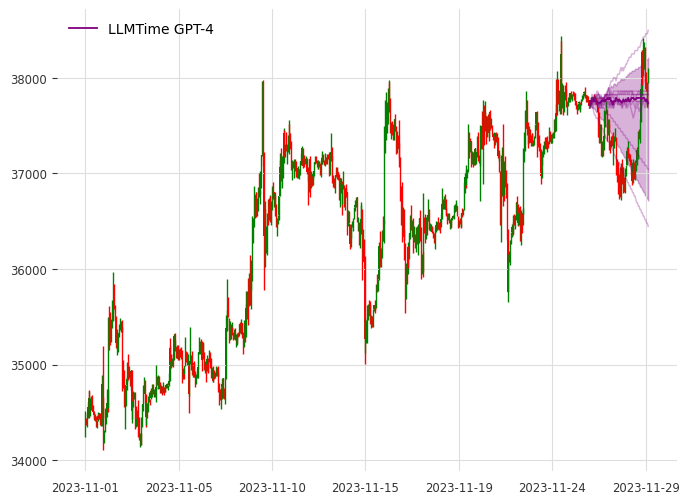

Data set : BTC_Daily_ohlc
from 2023-11-01 01:00:00 to 2023-11-29 10:00:00
682 data points, training on 562 and forecasting on 120 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_BitHourly'}) 
 with NLL inf


100%|██████████| 1/1 [00:20<00:00, 20.19s/it]


targets [37401. 37329. 37362. 37426. 37392. 37532. 37456. 37630. 37620. 37763.
 37731. 37797. 37810. 38252. 37770. 37880. 37750. 37796. 37856. 37853.
 37725. 37746. 37759. 37816. 37846. 37830. 37811. 37837. 37820. 37831.
 37790. 37764. 37713. 37678. 37741. 37749. 37705. 37728. 37771. 37798.
 37841. 37851. 37821. 37823. 37757. 37809. 37764. 37710. 37767. 37762.
 37788. 37801. 37804. 37814. 37784. 37788. 37728. 37706. 37641. 37547.
 37373. 37461. 37249. 37293. 37264. 37395. 37603. 37631. 37672. 37460.
 37506. 37509. 37322. 37322. 37383. 37307. 37284. 37299. 37348. 37369.
 37117. 37040. 36976. 36953. 36801. 36763. 37084. 36920. 36976. 36880.
 36807. 37036. 37086. 37240. 37267. 37202. 37183. 37132. 37002. 36922.
 37108. 37108. 36940. 37087. 37107. 37251. 37206. 37421. 37375. 37527.
 37885. 38273. 38023. 38151. 38274. 37972. 37885. 37839. 37940. 38060.]
median timestamp
2023-11-24 11:00:00    37391.150100
2023-11-24 12:00:00    37330.350200
2023-11-24 13:00:00    37336.864475
2023-11-24 14:

  0%|          | 0/1 [07:48<?, ?it/s]


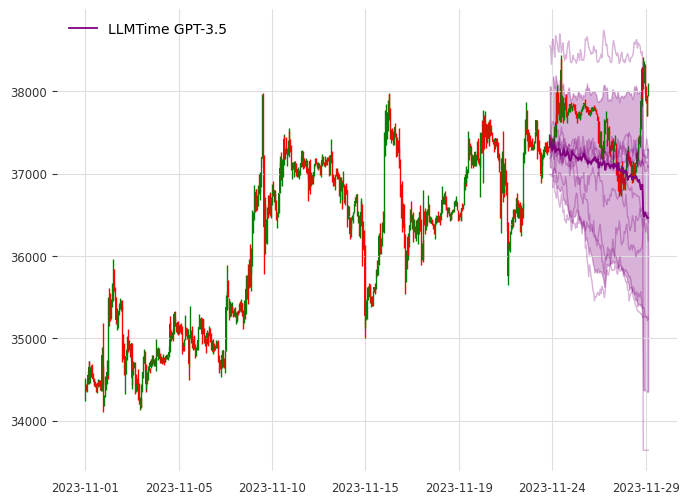

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_BitHourly'}) 
 with NLL inf


100%|██████████| 1/1 [00:16<00:00, 16.49s/it]


targets [37401. 37329. 37362. 37426. 37392. 37532. 37456. 37630. 37620. 37763.
 37731. 37797. 37810. 38252. 37770. 37880. 37750. 37796. 37856. 37853.
 37725. 37746. 37759. 37816. 37846. 37830. 37811. 37837. 37820. 37831.
 37790. 37764. 37713. 37678. 37741. 37749. 37705. 37728. 37771. 37798.
 37841. 37851. 37821. 37823. 37757. 37809. 37764. 37710. 37767. 37762.
 37788. 37801. 37804. 37814. 37784. 37788. 37728. 37706. 37641. 37547.
 37373. 37461. 37249. 37293. 37264. 37395. 37603. 37631. 37672. 37460.
 37506. 37509. 37322. 37322. 37383. 37307. 37284. 37299. 37348. 37369.
 37117. 37040. 36976. 36953. 36801. 36763. 37084. 36920. 36976. 36880.
 36807. 37036. 37086. 37240. 37267. 37202. 37183. 37132. 37002. 36922.
 37108. 37108. 36940. 37087. 37107. 37251. 37206. 37421. 37375. 37527.
 37885. 38273. 38023. 38151. 38274. 37972. 37885. 37839. 37940. 38060.]
median timestamp
2023-11-24 11:00:00    37386.22
2023-11-24 12:00:00    37403.88
2023-11-24 13:00:00    37403.88
2023-11-24 14:00:00    373

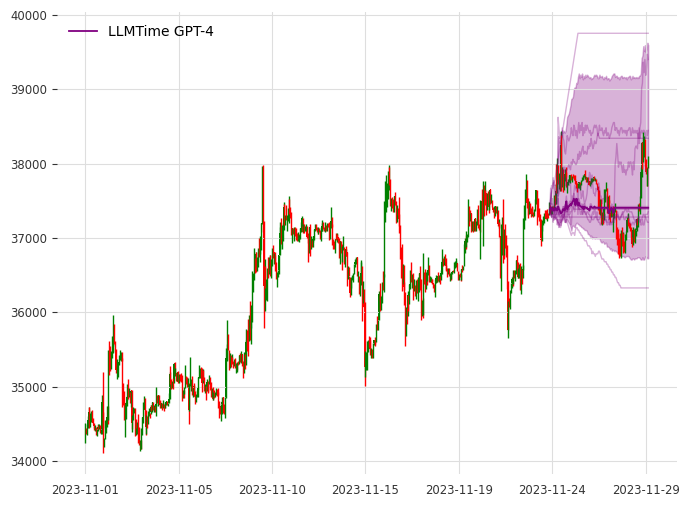

Data set : BTC_Daily_ohlc
from 2023-11-01 01:00:00 to 2023-11-29 10:00:00
682 data points, training on 514 and forecasting on 168 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_BitHourly'}) 
 with NLL inf


100%|██████████| 1/1 [00:28<00:00, 28.93s/it]


targets [36301. 36389. 36440. 36367. 36538. 36459. 36565. 36700. 36668. 36478.
 36570. 36597. 36400. 36496. 36475. 36586. 37197. 37299. 37652. 37652.
 37463. 37424. 37327. 37430. 37358. 37317. 37357. 37340. 37288. 37390.
 37515. 37646. 37471. 37372. 37308. 37256. 37218. 36972. 37093. 37174.
 37267. 37296. 37284. 37257. 37309. 37301. 37304. 37406. 37401. 37329.
 37362. 37426. 37392. 37532. 37456. 37630. 37620. 37763. 37731. 37797.
 37810. 38252. 37770. 37880. 37750. 37796. 37856. 37853. 37725. 37746.
 37759. 37816. 37846. 37830. 37811. 37837. 37820. 37831. 37790. 37764.
 37713. 37678. 37741. 37749. 37705. 37728. 37771. 37798. 37841. 37851.
 37821. 37823. 37757. 37809. 37764. 37710. 37767. 37762. 37788. 37801.
 37804. 37814. 37784. 37788. 37728. 37706. 37641. 37547. 37373. 37461.
 37249. 37293. 37264. 37395. 37603. 37631. 37672. 37460. 37506. 37509.
 37322. 37322. 37383. 37307. 37284. 37299. 37348. 37369. 37117. 37040.
 36976. 36953. 36801. 36763. 37084. 36920. 36976. 36880. 36807. 37036

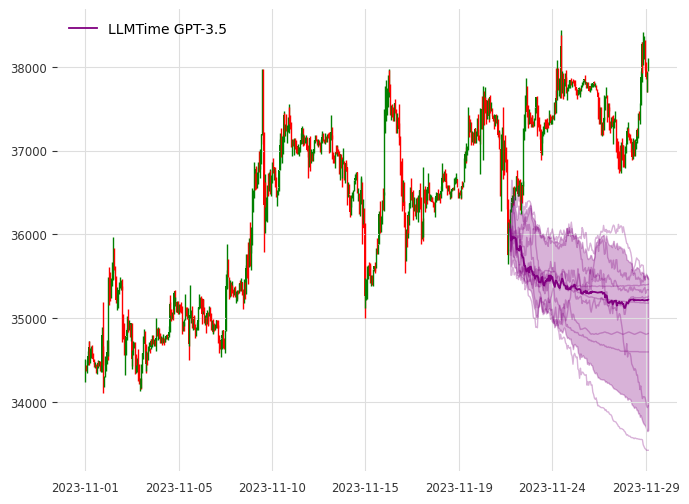

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_BitHourly'}) 
 with NLL inf


100%|██████████| 1/1 [00:23<00:00, 23.31s/it]


targets [36301. 36389. 36440. 36367. 36538. 36459. 36565. 36700. 36668. 36478.
 36570. 36597. 36400. 36496. 36475. 36586. 37197. 37299. 37652. 37652.
 37463. 37424. 37327. 37430. 37358. 37317. 37357. 37340. 37288. 37390.
 37515. 37646. 37471. 37372. 37308. 37256. 37218. 36972. 37093. 37174.
 37267. 37296. 37284. 37257. 37309. 37301. 37304. 37406. 37401. 37329.
 37362. 37426. 37392. 37532. 37456. 37630. 37620. 37763. 37731. 37797.
 37810. 38252. 37770. 37880. 37750. 37796. 37856. 37853. 37725. 37746.
 37759. 37816. 37846. 37830. 37811. 37837. 37820. 37831. 37790. 37764.
 37713. 37678. 37741. 37749. 37705. 37728. 37771. 37798. 37841. 37851.
 37821. 37823. 37757. 37809. 37764. 37710. 37767. 37762. 37788. 37801.
 37804. 37814. 37784. 37788. 37728. 37706. 37641. 37547. 37373. 37461.
 37249. 37293. 37264. 37395. 37603. 37631. 37672. 37460. 37506. 37509.
 37322. 37322. 37383. 37307. 37284. 37299. 37348. 37369. 37117. 37040.
 36976. 36953. 36801. 36763. 37084. 36920. 36976. 36880. 36807. 37036

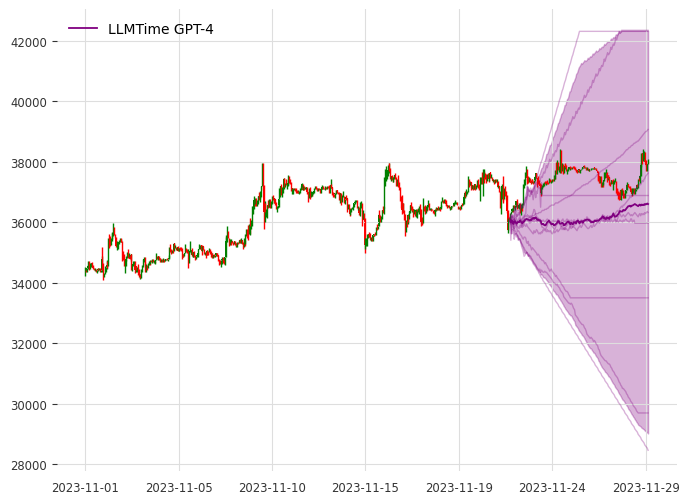

In [80]:
# datasets = get_bitcoin_datasets(predict_steps=30, start_date="2024-02-01")
# ds_name = 'BTC_BitHourly'
starting_date = '2023-11-01'
index = 0
for predict_step in [72,120,168] :

    with open(f"datasets/bitcoin/BTC_BitHourly.csv") as f:
        df = pd.read_csv(f, usecols=[0, 5], parse_dates=[0])
        mask = (df["timestamp"] > starting_date) 
        df = df.loc[mask]

        start_date = df["timestamp"].iloc[0]
        end_date = df["timestamp"].iloc[-1]

        print("Data set : BTC_Daily_ohlc")
        print(f"from {start_date} to {end_date}")
        print(f"{df.shape[0]} data points, training on {df.shape[0]- predict_step} and forecasting on {predict_step} points")
        print("Imput is scaled closing price")

    datasets = get_bitcoin_datasets_hourly(predict_steps=predict_step, timestamp="2023-11-01")
    ds_name = 'BTC_BitHourly'


    data = datasets[ds_name]
    train, test, df_raw = data # or change to your own data
    out = {}

    for i,model in enumerate(model_names): # GPT-4 takes a about a minute to run
        model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)

        targets = np.array(test)
        medians = pred_dict['median']
        print("targets", targets)
        print("median", medians)
        medians = medians.values

        maes = np.mean(np.abs(medians - test)) # (num_series)

        pred_dict['maes'] = maes
        pred_dict['mae'] = np.mean(maes)

        out[model] = pred_dict

        print("Raw list completion :")
        print(pred_dict["completions_list"])

        print("Model : ", model)
        print("MAE : ", pred_dict['mae'])
        print("MAES : ", pred_dict['maes']) 

        string = out[model]['input_strs']
        string = str(string)
        number_comma = 0
        for elt in string :
            # print(elt)
            if elt == ',' :
                number_comma += 1
        print("Sequence lenght : ", number_comma - 1)
        print("Raw scaled sequence")
        print(string)

        index += 1
        plot_preds_candles(df_raw ,train, test, pred_dict, model, show_samples=True, save_index=index)



        


In [79]:
# plot_preds_candles(df_raw ,train, test, pred_dict, model, show_samples=True, save_index=index)
print(medians.values)


[37711.05365  37694.410625 37665.879725 37713.431225 37713.431225
 37715.8088   37706.2985   37677.7676   37684.900325 37649.2367
 37644.48155  37589.797325 37649.2367   37627.838525 37663.50215
 37663.50215  37632.593675 37665.879725 37661.124575 37677.7676
 37656.369425 37706.2985   37706.2985   37665.879725 37663.50215
 37658.747    37642.103975 37682.52275  37661.124575 37634.97125
 37649.2367   37604.062775 37646.859125 37601.6852   37566.021575
 37573.1543   37618.328225 37582.6646   37580.287025 37518.470075
 37535.1131   37544.6234   37539.86825  37482.80645  37456.653125
 37456.653125 37499.449475 37508.959775 37480.428875 37470.918575
 37468.541    37518.470075 37535.1131   37511.33735  37516.0925
 37478.0513   37456.653125 37459.0307   37442.387675 37428.122225
 37501.82705  37551.756125 37466.163425 37577.90945  37613.573075
 37625.46095  37620.7058   37677.7676   37554.1337   37566.021575
 37487.5616   37525.6028  ]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


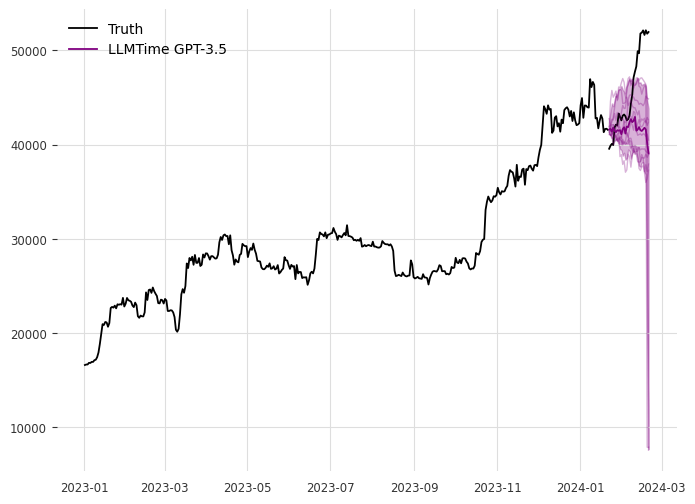

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.18s/it]

<Figure size 640x480 with 0 Axes>

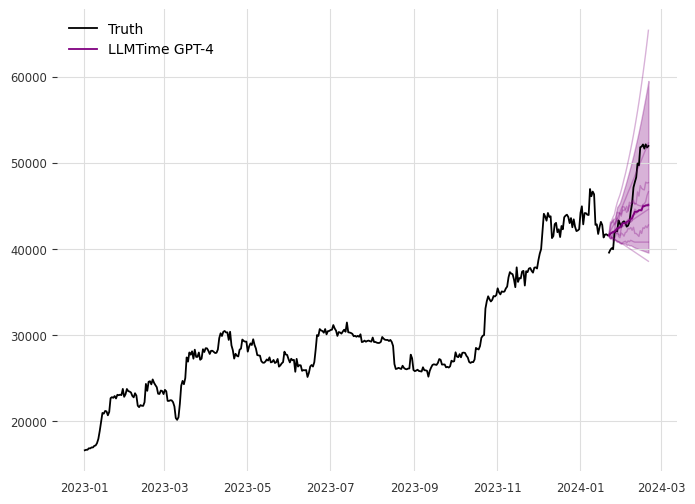

Model :  LLMTime GPT-3.5
Sequence lenght :  386
(' 2 5 2 , 2 5 4 , 2 5 4 , 2 5 9 , 2 5 8 , 2 6 1 , 2 6 1 , 2 6 6 , 2 6 8 , 2 7 5 , 2 8 9 , 3 1 4 , 3 4 4 , 3 7 3 , 3 7 0 , 3 7 9 , 3 7 8 , 3 6 5 , 3 7 6 , 4 2 0 , 4 2 3 , 4 2 1 , 4 2 7 , 4 1 9 , 4 3 1 , 4 3 0 , 4 3 1 , 4 3 0 , 4 5 0 , 4 2 4 , 4 3 3 , 4 5 0 , 4 4 3 , 4 4 1 , 4 3 8 , 4 2 7 , 4 2 3 , 4 3 6 , 4 2 8 , 3 9 6 , 3 9 1 , 3 9 8 , 3 9 6 , 3 9 5 , 4 0 7 , 4 6 6 , 4 4 4 , 4 7 3 , 4 7 5 , 4 6 5 , 4 8 0 , 4 7 0 , 4 6 2 , 4 5 5 , 4 3 4 , 4 3 4 , 4 4 5 , 4 4 3 , 4 3 3 , 4 4 7 , 4 4 2 , 4 1 1 , 4 1 1 , 4 1 4 , 4 1 3 , 4 0 7 , 3 9 3 , 3 5 6 , 3 5 0 , 3 5 9 , 4 0 2 , 4 6 0 , 4 7 6 , 4 6 5 , 4 8 5 , 5 5 1 , 5 3 8 , 5 6 7 , 5 6 0 , 5 7 1 , 5 4 7 , 5 7 6 , 5 5 3 , 5 5 3 , 5 6 7 , 5 4 4 , 5 4 8 , 5 7 8 , 5 6 9 , 5 8 1 , 5 8 1 , 5 7 3 , 5 6 3 , 5 7 3 , 5 7 3 , 5 6 9 , 5 6 6 , 5 6 6 , 5 7 7 , 6 1 4 , 6 2 9 , 6 2 1 , 6 3 4 , 6 3 7 , 6 3 2 , 6 3 2 , 6 0 8 , 6 3 4 , 5 9 0 , 5 7 5 , 5 4 8 , 5 6 3 , 5 5 7 , 5 5 5 , 5 7 6 , 5 8 0 , 6 0 9 , 6 0 5 , 6 0 2

100%|██████████| 1/1 [00:14<00:00, 14.16s/it]

<Figure size 640x480 with 0 Axes>

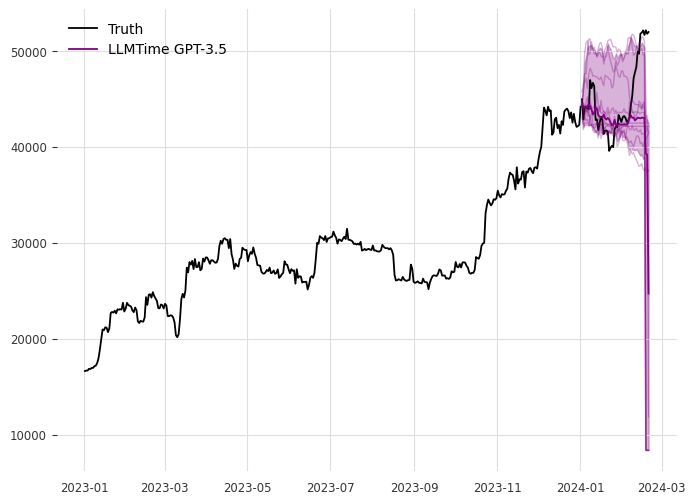

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:09<00:00,  9.30s/it]

<Figure size 640x480 with 0 Axes>

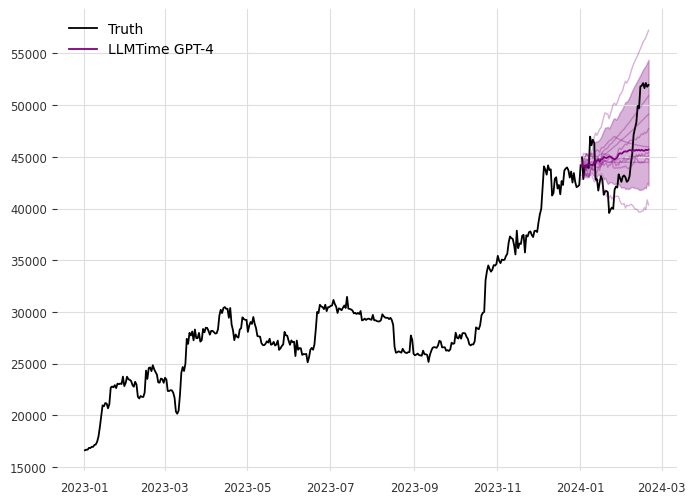

Model :  LLMTime GPT-3.5
Sequence lenght :  366
(' 2 4 2 , 2 4 4 , 2 4 4 , 2 4 9 , 2 4 8 , 2 5 2 , 2 5 2 , 2 5 7 , 2 5 8 , 2 6 6 , 2 8 1 , 3 0 7 , 3 3 9 , 3 6 9 , 3 6 7 , 3 7 6 , 3 7 4 , 3 6 1 , 3 7 3 , 4 1 9 , 4 2 3 , 4 2 1 , 4 2 7 , 4 1 8 , 4 3 1 , 4 2 9 , 4 3 1 , 4 3 0 , 4 5 1 , 4 2 4 , 4 3 3 , 4 5 1 , 4 4 3 , 4 4 2 , 4 3 9 , 4 2 7 , 4 2 2 , 4 3 6 , 4 2 8 , 3 9 4 , 3 8 9 , 3 9 6 , 3 9 3 , 3 9 3 , 4 0 6 , 4 6 8 , 4 4 4 , 4 7 5 , 4 7 7 , 4 6 6 , 4 8 3 , 4 7 2 , 4 6 4 , 4 5 7 , 4 3 5 , 4 3 4 , 4 4 5 , 4 4 4 , 4 3 3 , 4 4 8 , 4 4 3 , 4 1 0 , 4 1 0 , 4 1 2 , 4 1 2 , 4 0 6 , 3 9 1 , 3 5 2 , 3 4 6 , 3 5 5 , 4 0 0 , 4 6 2 , 4 7 8 , 4 6 7 , 4 8 8 , 5 5 8 , 5 4 4 , 5 7 5 , 5 6 7 , 5 7 9 , 5 5 4 , 5 8 4 , 5 6 0 , 5 6 0 , 5 7 5 , 5 5 0 , 5 5 4 , 5 8 6 , 5 7 7 , 5 8 9 , 5 8 9 , 5 8 1 , 5 7 0 , 5 8 1 , 5 8 1 , 5 7 7 , 5 7 3 , 5 7 4 , 5 8 5 , 6 2 4 , 6 4 0 , 6 3 1 , 6 4 5 , 6 4 8 , 6 4 3 , 6 4 3 , 6 1 8 , 6 4 6 , 5 9 9 , 5 8 3 , 5 5 4 , 5 7 0 , 5 6 4 , 5 6 1 , 5 8 5 , 5 8 8 , 6 1 9 , 6 1 4 , 6 1 2

100%|██████████| 1/1 [00:14<00:00, 14.53s/it]

<Figure size 640x480 with 0 Axes>

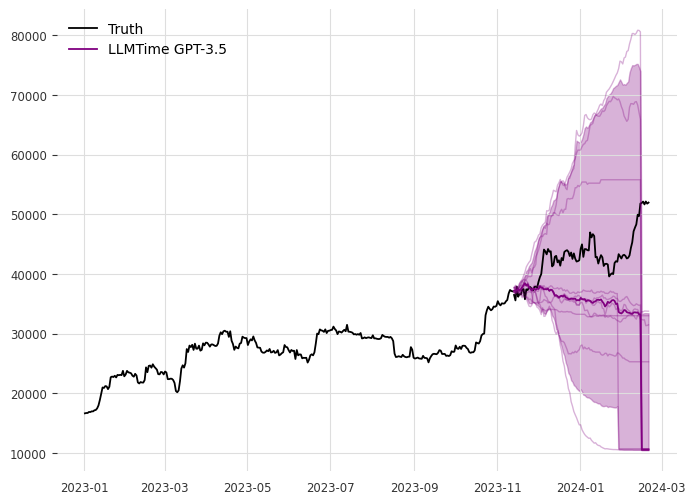

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:22<00:00, 22.34s/it]

<Figure size 640x480 with 0 Axes>

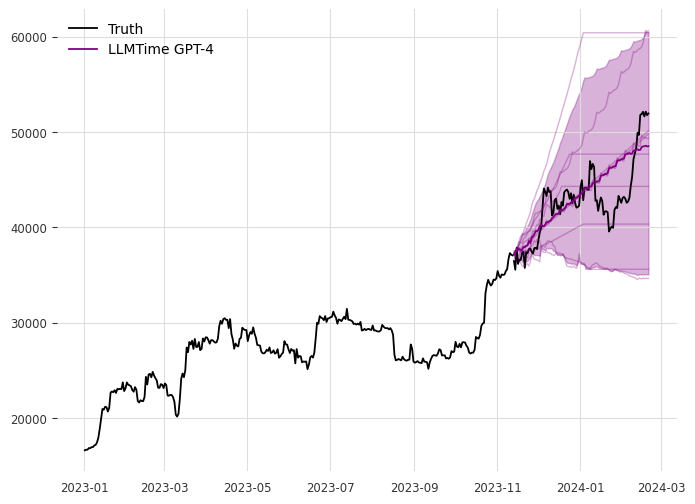

Model :  LLMTime GPT-3.5
Sequence lenght :  316
(' 2 6 0 , 2 6 2 , 2 6 2 , 2 7 0 , 2 6 9 , 2 7 4 , 2 7 4 , 2 8 1 , 2 8 4 , 2 9 5 , 3 1 6 , 3 5 4 , 3 9 9 , 4 4 2 , 4 3 9 , 4 5 2 , 4 5 0 , 4 3 0 , 4 4 7 , 5 1 4 , 5 1 9 , 5 1 6 , 5 2 4 , 5 1 3 , 5 3 1 , 5 2 8 , 5 3 1 , 5 2 9 , 5 5 9 , 5 2 1 , 5 3 3 , 5 5 9 , 5 4 8 , 5 4 6 , 5 4 2 , 5 2 5 , 5 1 8 , 5 3 8 , 5 2 6 , 4 7 7 , 4 7 0 , 4 8 0 , 4 7 7 , 4 7 6 , 4 9 4 , 5 8 4 , 5 5 0 , 5 9 4 , 5 9 6 , 5 8 1 , 6 0 5 , 5 8 9 , 5 7 8 , 5 6 7 , 5 3 6 , 5 3 5 , 5 5 1 , 5 4 9 , 5 3 4 , 5 5 4 , 5 4 7 , 5 0 1 , 5 0 1 , 5 0 4 , 5 0 3 , 4 9 4 , 4 7 4 , 4 1 7 , 4 0 8 , 4 2 1 , 4 8 6 , 5 7 5 , 5 9 8 , 5 8 2 , 6 1 2 , 7 1 2 , 6 9 2 , 7 3 7 , 7 2 6 , 7 4 2 , 7 0 6 , 7 5 0 , 7 1 5 , 7 1 5 , 7 3 7 , 7 0 1 , 7 0 7 , 7 5 2 , 7 3 9 , 7 5 7 , 7 5 7 , 7 4 5 , 7 2 9 , 7 4 5 , 7 4 5 , 7 3 9 , 7 3 4 , 7 3 5 , 7 5 1 , 8 0 7 , 8 3 0 , 8 1 7 , 8 3 8 , 8 4 1 , 8 3 4 , 8 3 5 , 7 9 8 , 8 3 8 , 7 7 1 , 7 4 8 , 7 0 7 , 7 3 0 , 7 2 1 , 7 1 7 , 7 5 0 , 7 5 5 , 8 0 0 , 7 9 3 , 7 9 0

<Figure size 640x480 with 0 Axes>

In [32]:
index = 0
for predict_step in [30,50,100] :
    starting_date = "2023-01-01"
    datasets = get_bitcoin_datasets(predict_steps=predict_step, start_date=starting_date)
    ds_name = 'BTC_Daily_ohlc'

    data = datasets[ds_name]
    train, test = data # or change to your own data
    out = {}
    for model in model_names: # GPT-4 takes a about a minute to run
        model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
        out[model] = pred_dict
        index += 1
        plot_preds(train, test, pred_dict, model, show_samples=True, save_index=index)


    for model in model_names[:-1]: # GPT-4 takes a about a minute to run
        print("Model : ", model)
        string = out[model]['input_strs']
        string = str(string)
        number_comma = 0
        for elt in string :
            # print(elt)
            if elt == ',' :
                number_comma += 1
        print("Sequence lenght : ", number_comma - 1)
        print(string)


    with open(f"datasets/bitcoin/BTC_Daily_ohlc.csv") as f:
        df = pd.read_csv(f, usecols=[0, 4], parse_dates=[0])
        mask = (df["date"] > starting_date) 
        df = df.loc[mask]

        start_date = df["date"].iloc[0]
        end_date = df["date"].iloc[-1]

        print("Data set : BTC_Daily_ohlc")
        print(f"from {start_date} to {end_date}")
        print(f"{df.shape[0]} data points, training on {df.shape[0]- predict_step} and forecasting on {predict_step} points")
        print("Imput is scaled closing price")

        # df['close'] = df['close'].astype(float)
        # series = pd.Series(df['close'].values, index=df['date'])


## Running LLMTime and Visualizing Results ##

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


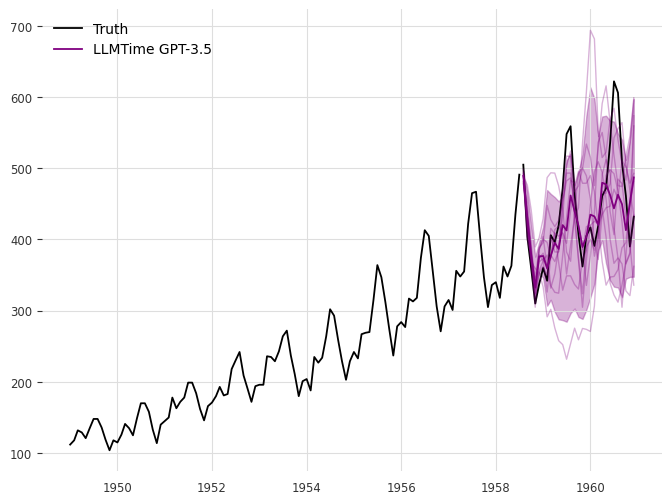

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.39s/it]


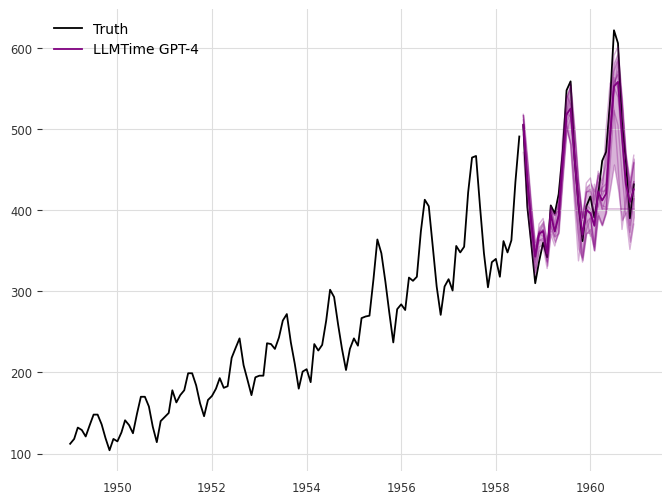

Train length: 86, Val length: 29


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 12, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
 with NLL 3.747898


/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


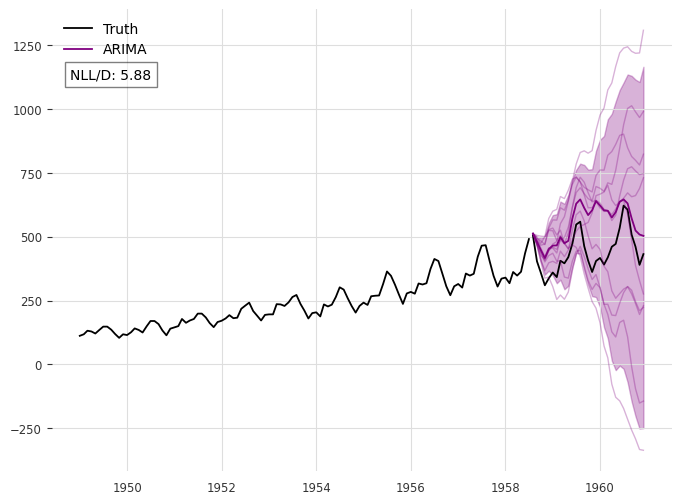

In [16]:
datasets = get_datasets()
ds_name = 'AirPassengersDataset'

data = datasets[ds_name]
train, test = data # or change to your own data
out = {}
for model in model_names: # GPT-4 takes a about a minute to run
    model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 10
    pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
    out[model] = pred_dict
    plot_preds(train, test, pred_dict, model, show_samples=True)